<a href="https://colab.research.google.com/github/SohaHussain/Generative-Deep-Learning/blob/main/02_Convolutional_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Convolutional Neural Network (CNN)

In this notebook, we'll walk through the steps required to train your own convolutional neural network (CNN) on the CIFAR dataset.

One of the reasons our MLP network isn’t yet performing as well as it might is because there isn’t anything in the network that takes into account the spatial structure of the input images. In fact, our first step is to flatten the image into a single vector, so that we can pass it to the first Dense layer!

**Convolution**

First, we need to understand what is meant by a convolution in the context of deep learning.

Suppose there are two different 3 × 3 × 1 portions of a grayscale image being convoluted with a 3 × 3 × 1 filter (or kernel). The convolution is performed by multiplying the filter pixelwise with the portion of the image, and summing the results. The output is more positive when the portion of the image closely matches the filter and more negative when the portion of the image is the inverse of the filter.

If we move the filter across the entire image from left to right and top to bottom, recording the convolutional output as we go, we obtain a new array that picks out a particular feature of the input, depending on the values in the filter.

**Convolutional layer**

A convolutional layer is simply a collection of filters, where the values stored in the filters are the weights that are learned by the neural network through training. Initially these are random, but gradually the filters adapt their weights to start picking out interesting features such as edges or particular color combinations.

###Preprocessing the dataset

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers, utils, datasets

In [2]:
NUM_CLASSES = 10

In [3]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

170498071/170498071 [==============================] - 11s 0us/step


In [4]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_test = utils.to_categorical(y_test, NUM_CLASSES)

###Dummy model for understanding

In [7]:
input_layer = layers.Input(shape=(32,32,3))

conv_layer_1 = layers.Conv2D(
    filters = 10
    , kernel_size = (4,4)
    , strides = 2
    , padding = 'same'
    )(input_layer)

conv_layer_2 = layers.Conv2D(
    filters = 20
    , kernel_size = (3,3)
    , strides = 2
    , padding = 'same'
    )(conv_layer_1)

flatten_layer = layers.Flatten()(conv_layer_2)

output_layer = layers.Dense(units=10, activation = 'softmax')(flatten_layer)

model = models.Model(input_layer, output_layer)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 10)        490       
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 20)          1820      
                                                                 
 flatten_1 (Flatten)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 10)                12810     
                                                                 
Total params: 15120 (59.06 KB)
Trainable params: 15120 (59.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**The above CNN model parameters in detail**

**Stride**

The strides parameter is the step size used by the layer to move the filters across the input. Increasing the stride therefore reduces the size of the output tensor. For example, when strides = 2, the height and width of the output tensor will be half the size of the input tensor. This is useful for reducing the spatial size of the tensor as it passes through the network, while increasing the number of channels.

**Padding**

The padding = "same" input parameter pads the input data with zeros so that the output size from the layer is exactly the same as the input size when strides = 1.Setting padding = "same" is a good way to ensure that you are able to easily keep track of the size of the tensor as it passes through many convolutional layers.

The output of a Conv2D layer is another four-dimensional tensor, now of shape (batch_size, height, width, filters), so we can stack Conv2D layers on top of each other to grow the depth of our neural network and make it more powerful.

Let’s walk through our network layer by layer, noting the shape of the tensor as we go:

* The input shape is (None, 32, 32, 3)—Keras uses None to represent the fact that we can pass any number of images through the network simultaneously. Since the network is just performing tensor algebra, we don’t need to pass images through the network individually, but instead can pass them through together as a batch.

* The shape of each of the 10 filters in the first convolutional layer is 4 × 4 × 3. This is because we have chosen each filter to have a height and width of 4 (kernel_size = (4,4)) and there are three channels in the preceding layer (red, green, and blue). Therefore, the number of parameters (or weights) in the layer is (4 × 4 × 3 + 1) × 10 = 490, where the + 1 is due to the inclusion of a bias term attached to each of the filters.

* The output from each filter will be the pixelwise multiplication of the filter weights and the 4 × 4 × 3 section of the image it is covering. As strides = 2 and padding = "same", the width and height of the output are both halved to 16, and since there are 10 filters the output of the first layer is a batch of tensors each having shape [16, 16, 10].

* In the second convolutional layer, we choose the filters to be 3 × 3 and they now have depth 10, to match the number of channels in the previous layer. Since there are 20 filters in this layer, this gives a total number of parameters (weights) of (3 × 3 × 10 + 1) × 20 = 1,820. Again, we use strides = 2 and padding = "same", so the width and height both halve. This gives us an overall output shape of (None, 8, 8, 20).

* We now flatten the tensor using the Keras Flatten layer. This results in a set of 8 × 8 × 20 = 1,280 units. Note that there are no parameters to learn in a Flatten layer as the operation is just a restructuring of the tensor.

* We finally connect these units to a 10-unit Dense layer with softmax activation, which represents the probability of each category in a 10-category classification task. This creates an extra 1,280 × 10 = 12,810 parameters (weights) to learn.



####Exploding gradients problem


When training a deep neural network the weights of the network should remain within a reasonable range of values, if they start to become too large, this is a sign that your network is suffering from what is known as the exploding gradient problem. As errors are propagated backward through the network, the calculation of the gradient in the earlier layers can sometimes grow exponentially large, causing wild fluctuations in the weight values.
If your loss function starts to return NaN, chances are that your weights have grown large enough to cause an overflow error.

**Root cause of exploding gradients**

One of the reasons for scaling input data to a neural network is to ensure a stable start to training over the first few iterations. Since the weights of the network are initially randomized, unscaled input could potentially create huge activation values that immediately lead to exploding gradients. For example, instead of passing pixel values from 0–255 into the input layer, we usually scale these values to between –1 and 1.
Because the input is scaled, it’s natural to expect the activations from all future layers to be relatively well scaled as well. Initially this may be true, but as the network trains and the weights move further away from their random initial values, this assumption can start to break down. This phenomenon is known as covariate shift.

#### Two techniques to improve model performance

**Batch Normalization**

It is a technique that drastically reduces the exploding gradients problem. During training, a batch normalization layer calculates the mean and standard deviation of each of its input channels across the batch and normalizes by subtracting the mean and dividing by the standard deviation. There are then two learned parameters for each channel, the scale (gamma) and shift (beta). The output is simply the normalized input, scaled by gamma and shifted by beta.

You might be wondering how this layer works at prediction time. When it comes to prediction, we may only want to predict a single observation, so there is no batch over which to calculate the mean and standard deviation. To get around this problem, during training a batch normalization layer also calculates the moving average of the mean and standard deviation of each channel and stores this value as part of the layer to use at test time.

**Dropout**

For deep learning, one of the most common technique to reduce overfitting is by using dropout layers. Dropout layers are very simple. During training, each dropout layer chooses a random set of units from the preceding layer and sets their output to 0. Incredibly, this simple addition drastically reduces overfitting by ensuring that the network doesn’t become overdependent on certain units or groups of units that, in effect, just remember observations from the training set. If we use dropout layers, the network cannot rely too much on any one unit and therefore knowledge is more evenly spread across the whole network. This makes the model much better at generalizing to unseen data, because the network has been trained to produce accurate predictions even under unfamiliar conditions, such as those caused by dropping random units. There are no weights to learn within a dropout layer, as the units to drop are decided stochastically. At prediction time, the dropout layer doesn’t drop any units, so that the full network is used to make predictions. Dropout layers are used most commonly after dense layers since these are the most prone to overfitting due to the higher number of weights, though you can also use them after convolutional layers.

###Building the model

In [8]:
input_layer = layers.Input((32, 32, 3))

x = layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(
    input_layer
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=32, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Flatten()(x)

x = layers.Dense(128)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Dropout(rate=0.5)(x)

x = layers.Dense(NUM_CLASSES)(x)
output_layer = layers.Activation("softmax")(x)

model = models.Model(input_layer, output_layer)

###Inspecting the model

In [9]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_5 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 batch_normalization_6 (Bat  (None, 16, 16, 32)        128       
 chNormalization)                                          

###Training the model

In [10]:
opt = optimizers.Adam(learning_rate=0.0005)
model.compile(
    loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"]
)

In [11]:
model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=10,
    shuffle=True,
    validation_data=(x_test, y_test),
)

Epoch 1/10
1563/1563 [==============================] - 183s 115ms/step - loss: 1.5629 - accuracy: 0.4502 - val_loss: 1.2548 - val_accuracy: 0.5550
Epoch 2/10
1563/1563 [==============================] - 177s 113ms/step - loss: 1.1674 - accuracy: 0.5861 - val_loss: 1.2471 - val_accuracy: 0.5779
Epoch 3/10
1563/1563 [==============================] - 172s 110ms/step - loss: 1.0066 - accuracy: 0.6473 - val_loss: 1.1023 - val_accuracy: 0.6132
Epoch 4/10
1563/1563 [==============================] - 169s 108ms/step - loss: 0.9151 - accuracy: 0.6790 - val_loss: 1.0056 - val_accuracy: 0.6539
Epoch 5/10
1563/1563 [==============================] - 172s 110ms/step - loss: 0.8586 - accuracy: 0.7004 - val_loss: 1.0936 - val_accuracy: 0.6214
Epoch 6/10
1563/1563 [==============================] - 171s 109ms/step - loss: 0.8067 - accuracy: 0.7203 - val_loss: 0.8253 - val_accuracy: 0.7058
Epoch 7/10
1563/1563 [==============================] - 168s 108ms/step - loss: 0.7648 - accuracy: 0.7341 - val_

###Evaluating the model

In [12]:
model.evaluate(x_test, y_test, batch_size=1000)

10/10 [==============================] - 13s 1s/step - loss: 0.8108 - accuracy: 0.7225


[0.8107689023017883, 0.7225000262260437]

In [13]:
CLASSES = np.array(
    [
        "airplane",
        "automobile",
        "bird",
        "cat",
        "deer",
        "dog",
        "frog",
        "horse",
        "ship",
        "truck",
    ]
)

preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_test, axis=-1)]

313/313 [==============================] - 12s 36ms/step


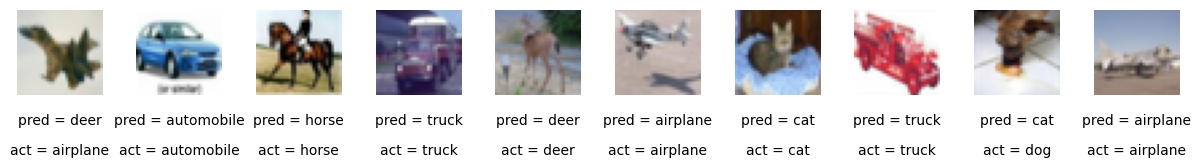

In [15]:
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        "pred = " + str(preds_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.text(
        0.5,
        -0.7,
        "act = " + str(actual_single[idx]),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(img)